In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
from string import uppercase
from captcha.image import ImageCaptcha

In [2]:
width = 100
height = 60
# charset = '0123456789'
charset = '0123456789' + uppercase
# captchaLength = 4
captchaLength = 1
imageSize = width * height
alpha = 1e-3

In [3]:
def getCode():
    return ''.join(map(
        lambda x: charset[x], 
        # np.random.randint(0, len(charset), captchaLength)  
        np.random.randint(0, len(charset), 4) # changed
    ))
captcha = ImageCaptcha(width=width, height=height)

In [4]:
def getData(n = 10):    
    codeList = [getCode() for _ in range(n)]
    imageList = map(lambda code: captcha.generate_image(code), codeList)
    return imageList, codeList


In [5]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)                                                                                                     
    return tf.Variable(initial)   

In [6]:
def bias_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)   

In [7]:
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [8]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def imageToVertor(image):
    """ 将图片转化为向量表示 """
    image = image.convert("L")
    image = np.asarray(image)
    image = image.reshape([width * height]) / 255
    return image

In [10]:
def codeToVertor(code):
    """ 将验证码转化为向量表示 """
    labels = np.zeros([captchaLength, len(charset)])
    for i in range(captchaLength):
        labels[i, charset.index(code[i])] = 1
    return labels.reshape(len(charset) * captchaLength)

JV9N


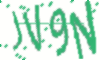

In [11]:
# 测试验证码
code = getCode()
print code
captcha.generate_image(code)

In [12]:
# 定义输入输出
x = tf.placeholder(tf.float32, shape=[None, imageSize])
y = tf.placeholder(tf.float32, shape=[None, len(charset) * captchaLength])   
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, shape=[-1, width, height, 1])

In [13]:
# 定义第一层卷积
conv_layer1_weight = weight_variable([5, 5, 1, 32])
conv_layer1_bias = bias_variable([32])
pool_layer1 = max_pool(
    tf.nn.relu(conv2d(x_image, conv_layer1_weight) + conv_layer1_bias))

In [14]:
# 定义第二层卷积
conv_layer2_weight = weight_variable([5, 5, 32, 64])
conv_layer2_bias = bias_variable([64])
pool_layer2 = max_pool(
    tf.nn.relu(conv2d(pool_layer1, conv_layer2_weight) + conv_layer2_bias)) 

In [15]:
# 定义第三层卷积
conv_layer3_weight = weight_variable([5, 5, 64, 64])
conv_layer3_bias = bias_variable([64])
pool_layer3 = max_pool(
    tf.nn.relu(conv2d(pool_layer2, conv_layer3_weight) + conv_layer3_bias))

In [16]:
lastWidth = int(round(width / 8))
lastHeight = int(round(height / 8))

In [17]:
# 定义全连接层
fc_layer_weight = weight_variable([lastWidth * lastHeight * 64, 1024])
fc_layer_bias = bias_variable([1024])
pool_layer3_flat = tf.reshape(pool_layer3, [-1, lastWidth * lastHeight * 64])
fc_layer = tf.nn.relu(tf.add(tf.matmul(pool_layer3_flat, fc_layer_weight), fc_layer_bias))

In [18]:
# Dropout层
fc_layer_drop = tf.nn.dropout(fc_layer, keep_prob)

In [19]:
# Readout层(输出层)
output_layer_weight = weight_variable([1024, len(charset) * captchaLength])   
output_layer_bias = bias_variable([len(charset) * captchaLength])              
y_conv = tf.add(tf.matmul(fc_layer_drop, output_layer_weight), output_layer_bias)

In [20]:
# 定义输出函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
prediction = tf.argmax(tf.reshape(y_conv, [-1, captchaLength, len(charset)]), 2)
correct = tf.argmax(tf.reshape(y, [-1, captchaLength, len(charset)]), 2)                                                           
correct_prediction = tf.equal(prediction, correct)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
# 初始化session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [22]:
for step in range(1, 10000 * 2):
    imageList, codeList = getData(100)
    codeList = map(lambda x: x[0], codeList) # changed 
    x_data = map(imageToVertor, imageList)
    y_data = map(codeToVertor, codeList)
    _, l, a = session.run([optimizer, loss, accuracy], feed_dict={x: x_data, y: y_data, keep_prob: .75})
    saver.save(session, 'model/model', global_step=step)
    print '[%d]: loss: %f accuracy: %f' % (step, l, a)

[1]: loss: 0.697307 accuracy: 0.020000
[2]: loss: 0.596522 accuracy: 0.020000
[3]: loss: 0.389936 accuracy: 0.030000
[4]: loss: 0.155670 accuracy: 0.020000
[5]: loss: 0.188770 accuracy: 0.020000
[6]: loss: 0.256280 accuracy: 0.040000
[7]: loss: 0.248415 accuracy: 0.040000
[8]: loss: 0.208110 accuracy: 0.030000
[9]: loss: 0.160855 accuracy: 0.030000
[10]: loss: 0.134583 accuracy: 0.030000
[11]: loss: 0.141604 accuracy: 0.020000
[12]: loss: 0.156127 accuracy: 0.050000
[13]: loss: 0.160095 accuracy: 0.040000
[14]: loss: 0.147518 accuracy: 0.040000
[15]: loss: 0.136376 accuracy: 0.020000
[16]: loss: 0.129830 accuracy: 0.020000
[17]: loss: 0.130922 accuracy: 0.010000
[18]: loss: 0.133369 accuracy: 0.030000
[19]: loss: 0.137714 accuracy: 0.020000
[20]: loss: 0.139422 accuracy: 0.040000
[21]: loss: 0.138043 accuracy: 0.050000
[22]: loss: 0.134286 accuracy: 0.060000
[23]: loss: 0.131144 accuracy: 0.030000
[24]: loss: 0.131160 accuracy: 0.030000
[25]: loss: 0.128784 accuracy: 0.020000
[26]: los

[204]: loss: 0.126992 accuracy: 0.060000
[205]: loss: 0.128147 accuracy: 0.030000
[206]: loss: 0.127581 accuracy: 0.050000
[207]: loss: 0.126554 accuracy: 0.040000
[208]: loss: 0.128240 accuracy: 0.020000
[209]: loss: 0.127532 accuracy: 0.040000
[210]: loss: 0.129148 accuracy: 0.030000
[211]: loss: 0.129129 accuracy: 0.000000
[212]: loss: 0.127680 accuracy: 0.010000
[213]: loss: 0.128722 accuracy: 0.010000
[214]: loss: 0.127845 accuracy: 0.040000
[215]: loss: 0.127926 accuracy: 0.040000
[216]: loss: 0.126758 accuracy: 0.040000
[217]: loss: 0.129287 accuracy: 0.030000
[218]: loss: 0.128296 accuracy: 0.030000
[219]: loss: 0.128553 accuracy: 0.020000
[220]: loss: 0.128818 accuracy: 0.000000
[221]: loss: 0.128700 accuracy: 0.030000
[222]: loss: 0.126836 accuracy: 0.040000
[223]: loss: 0.128377 accuracy: 0.040000
[224]: loss: 0.128479 accuracy: 0.010000
[225]: loss: 0.130643 accuracy: 0.010000
[226]: loss: 0.127392 accuracy: 0.050000
[227]: loss: 0.128083 accuracy: 0.020000
[228]: loss: 0.1

[404]: loss: 0.128512 accuracy: 0.040000
[405]: loss: 0.127822 accuracy: 0.030000
[406]: loss: 0.127838 accuracy: 0.010000
[407]: loss: 0.128110 accuracy: 0.020000
[408]: loss: 0.128531 accuracy: 0.030000
[409]: loss: 0.127693 accuracy: 0.000000
[410]: loss: 0.127647 accuracy: 0.010000
[411]: loss: 0.128061 accuracy: 0.010000
[412]: loss: 0.128092 accuracy: 0.020000
[413]: loss: 0.129109 accuracy: 0.020000
[414]: loss: 0.127438 accuracy: 0.010000
[415]: loss: 0.127772 accuracy: 0.030000
[416]: loss: 0.127237 accuracy: 0.030000
[417]: loss: 0.127117 accuracy: 0.040000
[418]: loss: 0.128892 accuracy: 0.020000
[419]: loss: 0.127113 accuracy: 0.050000
[420]: loss: 0.128246 accuracy: 0.000000
[421]: loss: 0.127836 accuracy: 0.020000
[422]: loss: 0.128444 accuracy: 0.040000
[423]: loss: 0.127102 accuracy: 0.010000
[424]: loss: 0.128159 accuracy: 0.010000
[425]: loss: 0.128952 accuracy: 0.010000
[426]: loss: 0.128916 accuracy: 0.010000
[427]: loss: 0.127642 accuracy: 0.000000
[428]: loss: 0.1

[604]: loss: 0.128671 accuracy: 0.040000
[605]: loss: 0.128176 accuracy: 0.050000
[606]: loss: 0.127517 accuracy: 0.050000
[607]: loss: 0.127078 accuracy: 0.050000
[608]: loss: 0.127995 accuracy: 0.010000
[609]: loss: 0.128026 accuracy: 0.030000
[610]: loss: 0.127106 accuracy: 0.030000
[611]: loss: 0.128109 accuracy: 0.010000
[612]: loss: 0.127632 accuracy: 0.050000
[613]: loss: 0.127645 accuracy: 0.040000
[614]: loss: 0.127865 accuracy: 0.020000
[615]: loss: 0.127625 accuracy: 0.030000
[616]: loss: 0.127506 accuracy: 0.030000
[617]: loss: 0.128267 accuracy: 0.010000
[618]: loss: 0.126793 accuracy: 0.050000
[619]: loss: 0.127439 accuracy: 0.010000
[620]: loss: 0.127266 accuracy: 0.060000
[621]: loss: 0.127278 accuracy: 0.020000
[622]: loss: 0.128166 accuracy: 0.010000
[623]: loss: 0.126982 accuracy: 0.020000
[624]: loss: 0.128099 accuracy: 0.040000
[625]: loss: 0.128158 accuracy: 0.030000
[626]: loss: 0.127395 accuracy: 0.050000
[627]: loss: 0.127936 accuracy: 0.020000
[628]: loss: 0.1

[804]: loss: 0.128307 accuracy: 0.010000
[805]: loss: 0.127053 accuracy: 0.030000
[806]: loss: 0.126807 accuracy: 0.040000
[807]: loss: 0.127135 accuracy: 0.030000
[808]: loss: 0.128543 accuracy: 0.010000
[809]: loss: 0.128138 accuracy: 0.010000
[810]: loss: 0.128054 accuracy: 0.040000
[811]: loss: 0.128018 accuracy: 0.020000
[812]: loss: 0.128078 accuracy: 0.020000
[813]: loss: 0.128038 accuracy: 0.030000
[814]: loss: 0.127132 accuracy: 0.050000
[815]: loss: 0.127495 accuracy: 0.010000
[816]: loss: 0.127839 accuracy: 0.020000
[817]: loss: 0.127825 accuracy: 0.030000
[818]: loss: 0.127380 accuracy: 0.030000
[819]: loss: 0.127717 accuracy: 0.040000
[820]: loss: 0.127923 accuracy: 0.070000
[821]: loss: 0.128012 accuracy: 0.030000
[822]: loss: 0.127332 accuracy: 0.020000
[823]: loss: 0.128315 accuracy: 0.010000
[824]: loss: 0.127335 accuracy: 0.040000
[825]: loss: 0.128293 accuracy: 0.010000
[826]: loss: 0.127100 accuracy: 0.030000
[827]: loss: 0.128426 accuracy: 0.000000
[828]: loss: 0.1

[1004]: loss: 0.129354 accuracy: 0.010000
[1005]: loss: 0.127504 accuracy: 0.020000
[1006]: loss: 0.127703 accuracy: 0.030000
[1007]: loss: 0.128108 accuracy: 0.040000
[1008]: loss: 0.128077 accuracy: 0.030000
[1009]: loss: 0.127575 accuracy: 0.030000
[1010]: loss: 0.128970 accuracy: 0.010000
[1011]: loss: 0.128860 accuracy: 0.020000
[1012]: loss: 0.127828 accuracy: 0.050000
[1013]: loss: 0.127500 accuracy: 0.030000
[1014]: loss: 0.128903 accuracy: 0.030000
[1015]: loss: 0.127471 accuracy: 0.050000
[1016]: loss: 0.126986 accuracy: 0.010000
[1017]: loss: 0.128085 accuracy: 0.020000
[1018]: loss: 0.127497 accuracy: 0.020000
[1019]: loss: 0.126711 accuracy: 0.040000
[1020]: loss: 0.127037 accuracy: 0.060000
[1021]: loss: 0.127757 accuracy: 0.020000
[1022]: loss: 0.127903 accuracy: 0.000000
[1023]: loss: 0.127291 accuracy: 0.030000
[1024]: loss: 0.127166 accuracy: 0.050000
[1025]: loss: 0.127526 accuracy: 0.030000
[1026]: loss: 0.128067 accuracy: 0.030000
[1027]: loss: 0.127146 accuracy: 0

[1200]: loss: 0.127188 accuracy: 0.040000
[1201]: loss: 0.127845 accuracy: 0.010000
[1202]: loss: 0.127218 accuracy: 0.050000
[1203]: loss: 0.127756 accuracy: 0.000000
[1204]: loss: 0.128534 accuracy: 0.040000
[1205]: loss: 0.127163 accuracy: 0.050000
[1206]: loss: 0.126488 accuracy: 0.040000
[1207]: loss: 0.128486 accuracy: 0.030000
[1208]: loss: 0.128409 accuracy: 0.000000
[1209]: loss: 0.128740 accuracy: 0.040000
[1210]: loss: 0.128677 accuracy: 0.050000
[1211]: loss: 0.127826 accuracy: 0.040000
[1212]: loss: 0.127151 accuracy: 0.050000
[1213]: loss: 0.128599 accuracy: 0.020000
[1214]: loss: 0.127334 accuracy: 0.030000
[1215]: loss: 0.127850 accuracy: 0.010000
[1216]: loss: 0.128036 accuracy: 0.030000
[1217]: loss: 0.127525 accuracy: 0.030000
[1218]: loss: 0.127288 accuracy: 0.020000
[1219]: loss: 0.128771 accuracy: 0.010000
[1220]: loss: 0.128365 accuracy: 0.070000
[1221]: loss: 0.127986 accuracy: 0.080000
[1222]: loss: 0.128305 accuracy: 0.010000
[1223]: loss: 0.127264 accuracy: 0

[1396]: loss: 0.126819 accuracy: 0.050000
[1397]: loss: 0.128008 accuracy: 0.020000
[1398]: loss: 0.127338 accuracy: 0.020000
[1399]: loss: 0.127499 accuracy: 0.020000
[1400]: loss: 0.127777 accuracy: 0.040000
[1401]: loss: 0.127270 accuracy: 0.060000
[1402]: loss: 0.128008 accuracy: 0.060000
[1403]: loss: 0.127872 accuracy: 0.020000
[1404]: loss: 0.127587 accuracy: 0.000000
[1405]: loss: 0.127219 accuracy: 0.030000
[1406]: loss: 0.126837 accuracy: 0.040000
[1407]: loss: 0.127865 accuracy: 0.000000
[1408]: loss: 0.127458 accuracy: 0.000000
[1409]: loss: 0.126833 accuracy: 0.020000
[1410]: loss: 0.127545 accuracy: 0.030000
[1411]: loss: 0.127239 accuracy: 0.020000
[1412]: loss: 0.127408 accuracy: 0.030000
[1413]: loss: 0.128400 accuracy: 0.030000
[1414]: loss: 0.128313 accuracy: 0.020000
[1415]: loss: 0.127264 accuracy: 0.010000
[1416]: loss: 0.127805 accuracy: 0.010000
[1417]: loss: 0.127918 accuracy: 0.010000
[1418]: loss: 0.127369 accuracy: 0.030000
[1419]: loss: 0.127186 accuracy: 0

[1592]: loss: 0.127697 accuracy: 0.050000
[1593]: loss: 0.127473 accuracy: 0.010000
[1594]: loss: 0.128119 accuracy: 0.000000
[1595]: loss: 0.127146 accuracy: 0.050000
[1596]: loss: 0.128359 accuracy: 0.010000
[1597]: loss: 0.127625 accuracy: 0.010000
[1598]: loss: 0.128061 accuracy: 0.040000
[1599]: loss: 0.126879 accuracy: 0.010000
[1600]: loss: 0.127572 accuracy: 0.020000
[1601]: loss: 0.127733 accuracy: 0.000000
[1602]: loss: 0.127019 accuracy: 0.030000
[1603]: loss: 0.127113 accuracy: 0.030000
[1604]: loss: 0.127097 accuracy: 0.060000
[1605]: loss: 0.126729 accuracy: 0.070000
[1606]: loss: 0.127306 accuracy: 0.030000
[1607]: loss: 0.127192 accuracy: 0.030000
[1608]: loss: 0.128470 accuracy: 0.020000
[1609]: loss: 0.127167 accuracy: 0.000000
[1610]: loss: 0.127405 accuracy: 0.010000
[1611]: loss: 0.128581 accuracy: 0.010000
[1612]: loss: 0.127988 accuracy: 0.040000
[1613]: loss: 0.126953 accuracy: 0.020000
[1614]: loss: 0.127811 accuracy: 0.030000
[1615]: loss: 0.128012 accuracy: 0

[1788]: loss: 0.126981 accuracy: 0.050000
[1789]: loss: 0.127389 accuracy: 0.040000
[1790]: loss: 0.126987 accuracy: 0.050000
[1791]: loss: 0.127317 accuracy: 0.030000
[1792]: loss: 0.127639 accuracy: 0.020000
[1793]: loss: 0.127638 accuracy: 0.020000
[1794]: loss: 0.128468 accuracy: 0.010000
[1795]: loss: 0.127624 accuracy: 0.000000
[1796]: loss: 0.127500 accuracy: 0.030000
[1797]: loss: 0.127881 accuracy: 0.020000
[1798]: loss: 0.127881 accuracy: 0.000000
[1799]: loss: 0.126919 accuracy: 0.060000
[1800]: loss: 0.127825 accuracy: 0.040000
[1801]: loss: 0.127609 accuracy: 0.010000
[1802]: loss: 0.127110 accuracy: 0.030000
[1803]: loss: 0.127349 accuracy: 0.030000
[1804]: loss: 0.127930 accuracy: 0.010000
[1805]: loss: 0.127451 accuracy: 0.020000
[1806]: loss: 0.127086 accuracy: 0.020000
[1807]: loss: 0.128291 accuracy: 0.020000
[1808]: loss: 0.127880 accuracy: 0.020000
[1809]: loss: 0.127840 accuracy: 0.040000
[1810]: loss: 0.127291 accuracy: 0.020000
[1811]: loss: 0.128479 accuracy: 0

[1984]: loss: 0.128093 accuracy: 0.030000
[1985]: loss: 0.128193 accuracy: 0.000000
[1986]: loss: 0.127370 accuracy: 0.010000
[1987]: loss: 0.127587 accuracy: 0.020000
[1988]: loss: 0.127846 accuracy: 0.000000
[1989]: loss: 0.127473 accuracy: 0.030000
[1990]: loss: 0.127415 accuracy: 0.020000
[1991]: loss: 0.127331 accuracy: 0.040000
[1992]: loss: 0.128486 accuracy: 0.010000
[1993]: loss: 0.126757 accuracy: 0.040000
[1994]: loss: 0.127699 accuracy: 0.010000
[1995]: loss: 0.127397 accuracy: 0.060000
[1996]: loss: 0.127451 accuracy: 0.030000
[1997]: loss: 0.127853 accuracy: 0.010000
[1998]: loss: 0.127590 accuracy: 0.010000
[1999]: loss: 0.127525 accuracy: 0.030000
[2000]: loss: 0.127791 accuracy: 0.010000
[2001]: loss: 0.127772 accuracy: 0.010000
[2002]: loss: 0.127380 accuracy: 0.010000
[2003]: loss: 0.128439 accuracy: 0.010000
[2004]: loss: 0.127396 accuracy: 0.020000
[2005]: loss: 0.126971 accuracy: 0.010000
[2006]: loss: 0.127007 accuracy: 0.020000
[2007]: loss: 0.127252 accuracy: 0

[2180]: loss: 0.127638 accuracy: 0.070000
[2181]: loss: 0.127984 accuracy: 0.020000
[2182]: loss: 0.128089 accuracy: 0.000000
[2183]: loss: 0.127143 accuracy: 0.030000
[2184]: loss: 0.127438 accuracy: 0.020000
[2185]: loss: 0.127019 accuracy: 0.040000
[2186]: loss: 0.128007 accuracy: 0.040000
[2187]: loss: 0.126957 accuracy: 0.050000
[2188]: loss: 0.127769 accuracy: 0.030000
[2189]: loss: 0.127729 accuracy: 0.040000
[2190]: loss: 0.127175 accuracy: 0.030000
[2191]: loss: 0.127116 accuracy: 0.060000
[2192]: loss: 0.127410 accuracy: 0.030000
[2193]: loss: 0.127477 accuracy: 0.060000
[2194]: loss: 0.127443 accuracy: 0.030000
[2195]: loss: 0.127293 accuracy: 0.030000
[2196]: loss: 0.127035 accuracy: 0.030000
[2197]: loss: 0.127020 accuracy: 0.030000
[2198]: loss: 0.128066 accuracy: 0.020000
[2199]: loss: 0.127985 accuracy: 0.010000
[2200]: loss: 0.127279 accuracy: 0.070000
[2201]: loss: 0.126927 accuracy: 0.030000
[2202]: loss: 0.127505 accuracy: 0.030000
[2203]: loss: 0.127633 accuracy: 0

[2376]: loss: 0.127664 accuracy: 0.040000
[2377]: loss: 0.127502 accuracy: 0.040000
[2378]: loss: 0.127663 accuracy: 0.020000
[2379]: loss: 0.126867 accuracy: 0.080000
[2380]: loss: 0.127265 accuracy: 0.010000
[2381]: loss: 0.128052 accuracy: 0.020000
[2382]: loss: 0.127784 accuracy: 0.010000
[2383]: loss: 0.127584 accuracy: 0.020000
[2384]: loss: 0.127866 accuracy: 0.020000
[2385]: loss: 0.127092 accuracy: 0.050000
[2386]: loss: 0.127725 accuracy: 0.050000
[2387]: loss: 0.127916 accuracy: 0.040000
[2388]: loss: 0.127628 accuracy: 0.020000
[2389]: loss: 0.128452 accuracy: 0.020000
[2390]: loss: 0.127218 accuracy: 0.000000
[2391]: loss: 0.126876 accuracy: 0.020000
[2392]: loss: 0.127888 accuracy: 0.030000
[2393]: loss: 0.127686 accuracy: 0.010000
[2394]: loss: 0.127588 accuracy: 0.030000
[2395]: loss: 0.127671 accuracy: 0.020000
[2396]: loss: 0.126992 accuracy: 0.030000
[2397]: loss: 0.128194 accuracy: 0.020000
[2398]: loss: 0.127175 accuracy: 0.020000
[2399]: loss: 0.128073 accuracy: 0

[2572]: loss: 0.126609 accuracy: 0.070000
[2573]: loss: 0.126905 accuracy: 0.030000
[2574]: loss: 0.127598 accuracy: 0.020000
[2575]: loss: 0.127174 accuracy: 0.010000
[2576]: loss: 0.126133 accuracy: 0.060000
[2577]: loss: 0.126938 accuracy: 0.070000
[2578]: loss: 0.126459 accuracy: 0.080000
[2579]: loss: 0.126038 accuracy: 0.040000
[2580]: loss: 0.126357 accuracy: 0.040000
[2581]: loss: 0.125659 accuracy: 0.070000
[2582]: loss: 0.127011 accuracy: 0.020000
[2583]: loss: 0.126799 accuracy: 0.050000
[2584]: loss: 0.126706 accuracy: 0.030000
[2585]: loss: 0.125922 accuracy: 0.070000
[2586]: loss: 0.126318 accuracy: 0.020000
[2587]: loss: 0.126241 accuracy: 0.020000
[2588]: loss: 0.126723 accuracy: 0.060000
[2589]: loss: 0.126283 accuracy: 0.050000
[2590]: loss: 0.126599 accuracy: 0.030000
[2591]: loss: 0.126324 accuracy: 0.060000
[2592]: loss: 0.125496 accuracy: 0.090000
[2593]: loss: 0.126261 accuracy: 0.080000
[2594]: loss: 0.125609 accuracy: 0.040000
[2595]: loss: 0.126460 accuracy: 0

[2768]: loss: 0.126941 accuracy: 0.050000
[2769]: loss: 0.128532 accuracy: 0.040000
[2770]: loss: 0.126489 accuracy: 0.020000
[2771]: loss: 0.126977 accuracy: 0.040000
[2772]: loss: 0.128237 accuracy: 0.040000
[2773]: loss: 0.128277 accuracy: 0.020000
[2774]: loss: 0.127941 accuracy: 0.010000
[2775]: loss: 0.127569 accuracy: 0.050000
[2776]: loss: 0.127753 accuracy: 0.030000
[2777]: loss: 0.127822 accuracy: 0.000000
[2778]: loss: 0.127362 accuracy: 0.040000
[2779]: loss: 0.127387 accuracy: 0.010000
[2780]: loss: 0.127260 accuracy: 0.040000
[2781]: loss: 0.127606 accuracy: 0.000000
[2782]: loss: 0.127735 accuracy: 0.020000
[2783]: loss: 0.127494 accuracy: 0.010000
[2784]: loss: 0.126869 accuracy: 0.060000
[2785]: loss: 0.126907 accuracy: 0.040000
[2786]: loss: 0.127243 accuracy: 0.040000
[2787]: loss: 0.127713 accuracy: 0.020000
[2788]: loss: 0.127105 accuracy: 0.020000
[2789]: loss: 0.126733 accuracy: 0.020000
[2790]: loss: 0.127013 accuracy: 0.010000
[2791]: loss: 0.127394 accuracy: 0

[2964]: loss: 0.127221 accuracy: 0.000000
[2965]: loss: 0.127639 accuracy: 0.040000
[2966]: loss: 0.128029 accuracy: 0.010000
[2967]: loss: 0.127518 accuracy: 0.010000
[2968]: loss: 0.127794 accuracy: 0.040000
[2969]: loss: 0.127790 accuracy: 0.020000
[2970]: loss: 0.127636 accuracy: 0.040000
[2971]: loss: 0.128193 accuracy: 0.000000
[2972]: loss: 0.127836 accuracy: 0.020000
[2973]: loss: 0.126855 accuracy: 0.030000
[2974]: loss: 0.127466 accuracy: 0.030000
[2975]: loss: 0.127126 accuracy: 0.040000
[2976]: loss: 0.127824 accuracy: 0.030000
[2977]: loss: 0.127774 accuracy: 0.040000
[2978]: loss: 0.126808 accuracy: 0.040000
[2979]: loss: 0.127871 accuracy: 0.030000
[2980]: loss: 0.126744 accuracy: 0.080000
[2981]: loss: 0.128397 accuracy: 0.000000
[2982]: loss: 0.126725 accuracy: 0.030000
[2983]: loss: 0.128046 accuracy: 0.030000
[2984]: loss: 0.126869 accuracy: 0.030000
[2985]: loss: 0.127977 accuracy: 0.010000
[2986]: loss: 0.127589 accuracy: 0.060000
[2987]: loss: 0.128101 accuracy: 0

[3160]: loss: 0.127268 accuracy: 0.060000
[3161]: loss: 0.127623 accuracy: 0.030000
[3162]: loss: 0.127510 accuracy: 0.030000
[3163]: loss: 0.128008 accuracy: 0.040000
[3164]: loss: 0.127082 accuracy: 0.020000
[3165]: loss: 0.126631 accuracy: 0.020000
[3166]: loss: 0.127119 accuracy: 0.040000
[3167]: loss: 0.127348 accuracy: 0.000000
[3168]: loss: 0.127541 accuracy: 0.020000
[3169]: loss: 0.127645 accuracy: 0.040000
[3170]: loss: 0.127628 accuracy: 0.010000
[3171]: loss: 0.127796 accuracy: 0.030000
[3172]: loss: 0.127831 accuracy: 0.000000
[3173]: loss: 0.127672 accuracy: 0.040000
[3174]: loss: 0.126995 accuracy: 0.030000
[3175]: loss: 0.128143 accuracy: 0.020000
[3176]: loss: 0.127954 accuracy: 0.020000
[3177]: loss: 0.127921 accuracy: 0.020000
[3178]: loss: 0.128867 accuracy: 0.000000
[3179]: loss: 0.128221 accuracy: 0.020000
[3180]: loss: 0.127711 accuracy: 0.020000
[3181]: loss: 0.127403 accuracy: 0.050000
[3182]: loss: 0.127961 accuracy: 0.010000
[3183]: loss: 0.127694 accuracy: 0

[3356]: loss: 0.127579 accuracy: 0.020000
[3357]: loss: 0.127266 accuracy: 0.020000
[3358]: loss: 0.127596 accuracy: 0.050000
[3359]: loss: 0.127507 accuracy: 0.030000
[3360]: loss: 0.127255 accuracy: 0.010000
[3361]: loss: 0.127351 accuracy: 0.070000
[3362]: loss: 0.127596 accuracy: 0.010000
[3363]: loss: 0.127371 accuracy: 0.020000
[3364]: loss: 0.127143 accuracy: 0.030000
[3365]: loss: 0.127107 accuracy: 0.050000
[3366]: loss: 0.127290 accuracy: 0.020000
[3367]: loss: 0.127430 accuracy: 0.030000
[3368]: loss: 0.127361 accuracy: 0.030000
[3369]: loss: 0.127893 accuracy: 0.030000
[3370]: loss: 0.127217 accuracy: 0.030000
[3371]: loss: 0.126823 accuracy: 0.090000
[3372]: loss: 0.127502 accuracy: 0.020000
[3373]: loss: 0.127524 accuracy: 0.050000
[3374]: loss: 0.127811 accuracy: 0.020000
[3375]: loss: 0.127402 accuracy: 0.010000
[3376]: loss: 0.127357 accuracy: 0.010000
[3377]: loss: 0.126599 accuracy: 0.050000
[3378]: loss: 0.126793 accuracy: 0.060000
[3379]: loss: 0.127739 accuracy: 0

[3552]: loss: 0.126152 accuracy: 0.040000
[3553]: loss: 0.127654 accuracy: 0.050000
[3554]: loss: 0.127376 accuracy: 0.020000
[3555]: loss: 0.127364 accuracy: 0.030000
[3556]: loss: 0.127304 accuracy: 0.010000
[3557]: loss: 0.127232 accuracy: 0.030000
[3558]: loss: 0.127238 accuracy: 0.020000
[3559]: loss: 0.126826 accuracy: 0.060000
[3560]: loss: 0.127435 accuracy: 0.030000
[3561]: loss: 0.126787 accuracy: 0.030000
[3562]: loss: 0.127664 accuracy: 0.000000
[3563]: loss: 0.127279 accuracy: 0.030000
[3564]: loss: 0.127484 accuracy: 0.030000
[3565]: loss: 0.127472 accuracy: 0.030000
[3566]: loss: 0.127489 accuracy: 0.030000
[3567]: loss: 0.127505 accuracy: 0.010000
[3568]: loss: 0.127960 accuracy: 0.030000
[3569]: loss: 0.127528 accuracy: 0.020000
[3570]: loss: 0.127399 accuracy: 0.010000
[3571]: loss: 0.127506 accuracy: 0.040000
[3572]: loss: 0.127348 accuracy: 0.020000
[3573]: loss: 0.127564 accuracy: 0.020000
[3574]: loss: 0.127897 accuracy: 0.040000
[3575]: loss: 0.127363 accuracy: 0

[3748]: loss: 0.123259 accuracy: 0.090000
[3749]: loss: 0.124579 accuracy: 0.080000
[3750]: loss: 0.124460 accuracy: 0.070000
[3751]: loss: 0.123744 accuracy: 0.070000
[3752]: loss: 0.125420 accuracy: 0.070000
[3753]: loss: 0.125333 accuracy: 0.060000
[3754]: loss: 0.125123 accuracy: 0.030000
[3755]: loss: 0.126521 accuracy: 0.050000
[3756]: loss: 0.125257 accuracy: 0.030000
[3757]: loss: 0.125886 accuracy: 0.010000
[3758]: loss: 0.123940 accuracy: 0.060000
[3759]: loss: 0.123764 accuracy: 0.060000
[3760]: loss: 0.123067 accuracy: 0.060000
[3761]: loss: 0.123349 accuracy: 0.100000
[3762]: loss: 0.121535 accuracy: 0.100000
[3763]: loss: 0.124985 accuracy: 0.080000
[3764]: loss: 0.123994 accuracy: 0.030000
[3765]: loss: 0.125490 accuracy: 0.080000
[3766]: loss: 0.122216 accuracy: 0.080000
[3767]: loss: 0.122987 accuracy: 0.070000
[3768]: loss: 0.125718 accuracy: 0.040000
[3769]: loss: 0.125131 accuracy: 0.070000
[3770]: loss: 0.123414 accuracy: 0.050000
[3771]: loss: 0.123602 accuracy: 0

[3944]: loss: 0.119882 accuracy: 0.100000
[3945]: loss: 0.114647 accuracy: 0.190000
[3946]: loss: 0.111522 accuracy: 0.200000
[3947]: loss: 0.115178 accuracy: 0.130000
[3948]: loss: 0.110720 accuracy: 0.190000
[3949]: loss: 0.111327 accuracy: 0.140000
[3950]: loss: 0.118662 accuracy: 0.110000
[3951]: loss: 0.112705 accuracy: 0.120000
[3952]: loss: 0.112642 accuracy: 0.060000
[3953]: loss: 0.115242 accuracy: 0.140000
[3954]: loss: 0.113732 accuracy: 0.130000
[3955]: loss: 0.113044 accuracy: 0.180000
[3956]: loss: 0.111833 accuracy: 0.150000
[3957]: loss: 0.115500 accuracy: 0.130000
[3958]: loss: 0.122392 accuracy: 0.050000
[3959]: loss: 0.111182 accuracy: 0.120000
[3960]: loss: 0.117962 accuracy: 0.110000
[3961]: loss: 0.118814 accuracy: 0.120000
[3962]: loss: 0.116346 accuracy: 0.110000
[3963]: loss: 0.115623 accuracy: 0.160000
[3964]: loss: 0.110849 accuracy: 0.150000
[3965]: loss: 0.115570 accuracy: 0.120000
[3966]: loss: 0.116335 accuracy: 0.110000
[3967]: loss: 0.114733 accuracy: 0

[4140]: loss: 0.104240 accuracy: 0.270000
[4141]: loss: 0.104106 accuracy: 0.210000
[4142]: loss: 0.104171 accuracy: 0.150000
[4143]: loss: 0.107141 accuracy: 0.190000
[4144]: loss: 0.108216 accuracy: 0.200000
[4145]: loss: 0.106016 accuracy: 0.170000
[4146]: loss: 0.107520 accuracy: 0.230000
[4147]: loss: 0.111143 accuracy: 0.140000
[4148]: loss: 0.102696 accuracy: 0.220000
[4149]: loss: 0.104466 accuracy: 0.170000
[4150]: loss: 0.105679 accuracy: 0.160000
[4151]: loss: 0.102426 accuracy: 0.220000
[4152]: loss: 0.102446 accuracy: 0.210000
[4153]: loss: 0.107452 accuracy: 0.210000
[4154]: loss: 0.104273 accuracy: 0.220000
[4155]: loss: 0.107693 accuracy: 0.180000
[4156]: loss: 0.107953 accuracy: 0.220000
[4157]: loss: 0.111482 accuracy: 0.150000
[4158]: loss: 0.105131 accuracy: 0.200000
[4159]: loss: 0.105705 accuracy: 0.190000
[4160]: loss: 0.101996 accuracy: 0.290000
[4161]: loss: 0.107850 accuracy: 0.200000
[4162]: loss: 0.104172 accuracy: 0.200000
[4163]: loss: 0.100516 accuracy: 0

[4336]: loss: 0.081180 accuracy: 0.340000
[4337]: loss: 0.086366 accuracy: 0.350000
[4338]: loss: 0.088296 accuracy: 0.310000
[4339]: loss: 0.088467 accuracy: 0.310000
[4340]: loss: 0.083810 accuracy: 0.410000
[4341]: loss: 0.086883 accuracy: 0.370000
[4342]: loss: 0.085260 accuracy: 0.310000
[4343]: loss: 0.082536 accuracy: 0.390000
[4344]: loss: 0.085133 accuracy: 0.390000
[4345]: loss: 0.082384 accuracy: 0.410000
[4346]: loss: 0.083643 accuracy: 0.380000
[4347]: loss: 0.083069 accuracy: 0.360000
[4348]: loss: 0.080309 accuracy: 0.340000
[4349]: loss: 0.082396 accuracy: 0.400000
[4350]: loss: 0.085926 accuracy: 0.370000
[4351]: loss: 0.084756 accuracy: 0.410000
[4352]: loss: 0.081088 accuracy: 0.420000
[4353]: loss: 0.079997 accuracy: 0.430000
[4354]: loss: 0.085256 accuracy: 0.360000
[4355]: loss: 0.086089 accuracy: 0.350000
[4356]: loss: 0.082573 accuracy: 0.430000
[4357]: loss: 0.081678 accuracy: 0.410000
[4358]: loss: 0.085814 accuracy: 0.340000
[4359]: loss: 0.081817 accuracy: 0

[4532]: loss: 0.068394 accuracy: 0.490000
[4533]: loss: 0.070231 accuracy: 0.520000
[4534]: loss: 0.071729 accuracy: 0.480000
[4535]: loss: 0.068384 accuracy: 0.530000
[4536]: loss: 0.067751 accuracy: 0.540000
[4537]: loss: 0.066597 accuracy: 0.460000
[4538]: loss: 0.069792 accuracy: 0.510000
[4539]: loss: 0.071405 accuracy: 0.430000
[4540]: loss: 0.066852 accuracy: 0.540000
[4541]: loss: 0.059011 accuracy: 0.610000
[4542]: loss: 0.063326 accuracy: 0.590000
[4543]: loss: 0.068795 accuracy: 0.540000
[4544]: loss: 0.065185 accuracy: 0.570000
[4545]: loss: 0.070668 accuracy: 0.440000
[4546]: loss: 0.066176 accuracy: 0.450000
[4547]: loss: 0.068438 accuracy: 0.490000
[4548]: loss: 0.065246 accuracy: 0.500000
[4549]: loss: 0.068219 accuracy: 0.410000
[4550]: loss: 0.070337 accuracy: 0.530000
[4551]: loss: 0.070821 accuracy: 0.470000
[4552]: loss: 0.072487 accuracy: 0.490000
[4553]: loss: 0.076758 accuracy: 0.420000
[4554]: loss: 0.062969 accuracy: 0.570000
[4555]: loss: 0.068296 accuracy: 0

[4728]: loss: 0.065207 accuracy: 0.510000
[4729]: loss: 0.059299 accuracy: 0.610000
[4730]: loss: 0.065059 accuracy: 0.520000
[4731]: loss: 0.061721 accuracy: 0.560000
[4732]: loss: 0.055424 accuracy: 0.590000
[4733]: loss: 0.057596 accuracy: 0.630000
[4734]: loss: 0.072606 accuracy: 0.490000
[4735]: loss: 0.049396 accuracy: 0.680000
[4736]: loss: 0.057662 accuracy: 0.580000
[4737]: loss: 0.053416 accuracy: 0.630000
[4738]: loss: 0.061167 accuracy: 0.590000
[4739]: loss: 0.060922 accuracy: 0.560000
[4740]: loss: 0.062916 accuracy: 0.540000
[4741]: loss: 0.060767 accuracy: 0.600000
[4742]: loss: 0.058662 accuracy: 0.550000
[4743]: loss: 0.060063 accuracy: 0.530000
[4744]: loss: 0.064036 accuracy: 0.570000
[4745]: loss: 0.056388 accuracy: 0.580000
[4746]: loss: 0.063282 accuracy: 0.600000
[4747]: loss: 0.065106 accuracy: 0.610000
[4748]: loss: 0.053412 accuracy: 0.630000
[4749]: loss: 0.055389 accuracy: 0.610000
[4750]: loss: 0.055440 accuracy: 0.580000
[4751]: loss: 0.052046 accuracy: 0

[4924]: loss: 0.056090 accuracy: 0.600000
[4925]: loss: 0.052844 accuracy: 0.680000
[4926]: loss: 0.051432 accuracy: 0.670000
[4927]: loss: 0.046319 accuracy: 0.700000
[4928]: loss: 0.058499 accuracy: 0.590000
[4929]: loss: 0.051739 accuracy: 0.690000
[4930]: loss: 0.052713 accuracy: 0.670000
[4931]: loss: 0.052390 accuracy: 0.660000
[4932]: loss: 0.045731 accuracy: 0.720000
[4933]: loss: 0.055003 accuracy: 0.560000
[4934]: loss: 0.052945 accuracy: 0.600000
[4935]: loss: 0.043174 accuracy: 0.740000
[4936]: loss: 0.052536 accuracy: 0.580000
[4937]: loss: 0.058736 accuracy: 0.660000
[4938]: loss: 0.063607 accuracy: 0.570000
[4939]: loss: 0.055561 accuracy: 0.650000
[4940]: loss: 0.045763 accuracy: 0.720000
[4941]: loss: 0.057587 accuracy: 0.630000
[4942]: loss: 0.056204 accuracy: 0.600000
[4943]: loss: 0.052297 accuracy: 0.650000
[4944]: loss: 0.057136 accuracy: 0.620000
[4945]: loss: 0.047439 accuracy: 0.720000
[4946]: loss: 0.042047 accuracy: 0.730000
[4947]: loss: 0.051551 accuracy: 0

[5120]: loss: 0.041691 accuracy: 0.700000
[5121]: loss: 0.043698 accuracy: 0.690000
[5122]: loss: 0.046915 accuracy: 0.670000
[5123]: loss: 0.053846 accuracy: 0.620000
[5124]: loss: 0.043034 accuracy: 0.710000
[5125]: loss: 0.046824 accuracy: 0.680000
[5126]: loss: 0.055567 accuracy: 0.620000
[5127]: loss: 0.053757 accuracy: 0.650000
[5128]: loss: 0.050645 accuracy: 0.630000
[5129]: loss: 0.048846 accuracy: 0.630000
[5130]: loss: 0.042631 accuracy: 0.730000
[5131]: loss: 0.055400 accuracy: 0.670000
[5132]: loss: 0.039261 accuracy: 0.760000
[5133]: loss: 0.046241 accuracy: 0.700000
[5134]: loss: 0.051339 accuracy: 0.670000
[5135]: loss: 0.042714 accuracy: 0.670000
[5136]: loss: 0.048825 accuracy: 0.660000
[5137]: loss: 0.056298 accuracy: 0.580000
[5138]: loss: 0.050781 accuracy: 0.600000
[5139]: loss: 0.050333 accuracy: 0.650000
[5140]: loss: 0.047548 accuracy: 0.740000
[5141]: loss: 0.044540 accuracy: 0.720000
[5142]: loss: 0.046466 accuracy: 0.660000
[5143]: loss: 0.047939 accuracy: 0

[5316]: loss: 0.042935 accuracy: 0.690000
[5317]: loss: 0.045325 accuracy: 0.640000
[5318]: loss: 0.045037 accuracy: 0.710000
[5319]: loss: 0.051437 accuracy: 0.600000
[5320]: loss: 0.062425 accuracy: 0.560000
[5321]: loss: 0.040661 accuracy: 0.740000
[5322]: loss: 0.043499 accuracy: 0.700000
[5323]: loss: 0.046244 accuracy: 0.680000
[5324]: loss: 0.044248 accuracy: 0.730000
[5325]: loss: 0.046635 accuracy: 0.710000
[5326]: loss: 0.045561 accuracy: 0.680000
[5327]: loss: 0.035828 accuracy: 0.790000
[5328]: loss: 0.039566 accuracy: 0.760000
[5329]: loss: 0.047809 accuracy: 0.650000
[5330]: loss: 0.046457 accuracy: 0.670000
[5331]: loss: 0.047268 accuracy: 0.620000
[5332]: loss: 0.041300 accuracy: 0.720000
[5333]: loss: 0.040267 accuracy: 0.730000
[5334]: loss: 0.047449 accuracy: 0.680000
[5335]: loss: 0.035114 accuracy: 0.790000
[5336]: loss: 0.033451 accuracy: 0.820000
[5337]: loss: 0.041147 accuracy: 0.710000
[5338]: loss: 0.045852 accuracy: 0.670000
[5339]: loss: 0.047600 accuracy: 0

[5512]: loss: 0.036023 accuracy: 0.770000
[5513]: loss: 0.038550 accuracy: 0.750000
[5514]: loss: 0.036213 accuracy: 0.810000
[5515]: loss: 0.052267 accuracy: 0.650000
[5516]: loss: 0.033076 accuracy: 0.800000
[5517]: loss: 0.035542 accuracy: 0.740000
[5518]: loss: 0.040987 accuracy: 0.680000
[5519]: loss: 0.031106 accuracy: 0.810000
[5520]: loss: 0.035229 accuracy: 0.790000
[5521]: loss: 0.035103 accuracy: 0.750000
[5522]: loss: 0.039339 accuracy: 0.740000
[5523]: loss: 0.033284 accuracy: 0.750000
[5524]: loss: 0.028778 accuracy: 0.810000
[5525]: loss: 0.040383 accuracy: 0.780000
[5526]: loss: 0.037513 accuracy: 0.740000
[5527]: loss: 0.033597 accuracy: 0.750000
[5528]: loss: 0.036677 accuracy: 0.770000
[5529]: loss: 0.029548 accuracy: 0.850000
[5530]: loss: 0.039706 accuracy: 0.710000
[5531]: loss: 0.042045 accuracy: 0.720000
[5532]: loss: 0.032843 accuracy: 0.790000
[5533]: loss: 0.038138 accuracy: 0.760000
[5534]: loss: 0.044911 accuracy: 0.700000
[5535]: loss: 0.034440 accuracy: 0

[5708]: loss: 0.036891 accuracy: 0.740000
[5709]: loss: 0.034183 accuracy: 0.770000
[5710]: loss: 0.036196 accuracy: 0.770000
[5711]: loss: 0.031651 accuracy: 0.790000
[5712]: loss: 0.030618 accuracy: 0.810000
[5713]: loss: 0.029119 accuracy: 0.830000
[5714]: loss: 0.037916 accuracy: 0.740000
[5715]: loss: 0.033306 accuracy: 0.780000
[5716]: loss: 0.036027 accuracy: 0.780000
[5717]: loss: 0.034180 accuracy: 0.760000
[5718]: loss: 0.040253 accuracy: 0.740000
[5719]: loss: 0.034450 accuracy: 0.790000
[5720]: loss: 0.034578 accuracy: 0.780000
[5721]: loss: 0.036007 accuracy: 0.740000
[5722]: loss: 0.036952 accuracy: 0.720000
[5723]: loss: 0.036015 accuracy: 0.720000
[5724]: loss: 0.029334 accuracy: 0.800000
[5725]: loss: 0.035641 accuracy: 0.770000
[5726]: loss: 0.030164 accuracy: 0.830000
[5727]: loss: 0.029261 accuracy: 0.810000
[5728]: loss: 0.031011 accuracy: 0.790000
[5729]: loss: 0.028249 accuracy: 0.860000
[5730]: loss: 0.029460 accuracy: 0.800000
[5731]: loss: 0.035947 accuracy: 0

[5904]: loss: 0.034164 accuracy: 0.780000
[5905]: loss: 0.029444 accuracy: 0.810000
[5906]: loss: 0.030904 accuracy: 0.810000
[5907]: loss: 0.031687 accuracy: 0.820000
[5908]: loss: 0.032147 accuracy: 0.750000
[5909]: loss: 0.028701 accuracy: 0.820000
[5910]: loss: 0.032701 accuracy: 0.750000
[5911]: loss: 0.025513 accuracy: 0.810000
[5912]: loss: 0.031522 accuracy: 0.800000
[5913]: loss: 0.029016 accuracy: 0.810000
[5914]: loss: 0.035204 accuracy: 0.740000
[5915]: loss: 0.040131 accuracy: 0.720000
[5916]: loss: 0.031332 accuracy: 0.800000
[5917]: loss: 0.031213 accuracy: 0.800000
[5918]: loss: 0.027542 accuracy: 0.840000
[5919]: loss: 0.035798 accuracy: 0.750000
[5920]: loss: 0.030028 accuracy: 0.820000
[5921]: loss: 0.038666 accuracy: 0.730000
[5922]: loss: 0.035750 accuracy: 0.750000
[5923]: loss: 0.028985 accuracy: 0.840000
[5924]: loss: 0.034604 accuracy: 0.770000
[5925]: loss: 0.028130 accuracy: 0.830000
[5926]: loss: 0.038288 accuracy: 0.640000
[5927]: loss: 0.037653 accuracy: 0

[6100]: loss: 0.035596 accuracy: 0.760000
[6101]: loss: 0.029384 accuracy: 0.790000
[6102]: loss: 0.027371 accuracy: 0.830000
[6103]: loss: 0.025820 accuracy: 0.840000
[6104]: loss: 0.034534 accuracy: 0.790000
[6105]: loss: 0.030243 accuracy: 0.780000
[6106]: loss: 0.026827 accuracy: 0.860000
[6107]: loss: 0.030820 accuracy: 0.790000
[6108]: loss: 0.032823 accuracy: 0.780000
[6109]: loss: 0.031145 accuracy: 0.820000
[6110]: loss: 0.028319 accuracy: 0.870000
[6111]: loss: 0.025798 accuracy: 0.850000
[6112]: loss: 0.031802 accuracy: 0.830000
[6113]: loss: 0.032780 accuracy: 0.810000
[6114]: loss: 0.027803 accuracy: 0.840000
[6115]: loss: 0.024293 accuracy: 0.870000
[6116]: loss: 0.031669 accuracy: 0.800000
[6117]: loss: 0.029039 accuracy: 0.830000
[6118]: loss: 0.032385 accuracy: 0.810000
[6119]: loss: 0.035155 accuracy: 0.760000
[6120]: loss: 0.036412 accuracy: 0.830000
[6121]: loss: 0.025830 accuracy: 0.860000
[6122]: loss: 0.027660 accuracy: 0.820000
[6123]: loss: 0.029505 accuracy: 0

[6296]: loss: 0.024930 accuracy: 0.850000
[6297]: loss: 0.028264 accuracy: 0.800000
[6298]: loss: 0.029056 accuracy: 0.820000
[6299]: loss: 0.025409 accuracy: 0.860000
[6300]: loss: 0.023491 accuracy: 0.860000
[6301]: loss: 0.028043 accuracy: 0.810000
[6302]: loss: 0.027444 accuracy: 0.850000
[6303]: loss: 0.032071 accuracy: 0.710000
[6304]: loss: 0.024255 accuracy: 0.890000
[6305]: loss: 0.029753 accuracy: 0.810000
[6306]: loss: 0.028067 accuracy: 0.820000
[6307]: loss: 0.032672 accuracy: 0.780000
[6308]: loss: 0.026781 accuracy: 0.860000
[6309]: loss: 0.031252 accuracy: 0.790000
[6310]: loss: 0.036466 accuracy: 0.780000
[6311]: loss: 0.032945 accuracy: 0.750000
[6312]: loss: 0.029874 accuracy: 0.800000
[6313]: loss: 0.032501 accuracy: 0.800000
[6314]: loss: 0.028630 accuracy: 0.860000
[6315]: loss: 0.022870 accuracy: 0.870000
[6316]: loss: 0.027801 accuracy: 0.840000
[6317]: loss: 0.021991 accuracy: 0.900000
[6318]: loss: 0.025829 accuracy: 0.860000
[6319]: loss: 0.038544 accuracy: 0

[6492]: loss: 0.031587 accuracy: 0.790000
[6493]: loss: 0.019960 accuracy: 0.920000
[6494]: loss: 0.032342 accuracy: 0.740000
[6495]: loss: 0.022808 accuracy: 0.900000
[6496]: loss: 0.027790 accuracy: 0.830000
[6497]: loss: 0.030559 accuracy: 0.790000
[6498]: loss: 0.034329 accuracy: 0.770000
[6499]: loss: 0.022936 accuracy: 0.860000
[6500]: loss: 0.030278 accuracy: 0.800000
[6501]: loss: 0.027649 accuracy: 0.800000
[6502]: loss: 0.027613 accuracy: 0.820000
[6503]: loss: 0.023936 accuracy: 0.870000
[6504]: loss: 0.025085 accuracy: 0.850000
[6505]: loss: 0.027183 accuracy: 0.820000
[6506]: loss: 0.025142 accuracy: 0.860000
[6507]: loss: 0.026428 accuracy: 0.810000
[6508]: loss: 0.031482 accuracy: 0.770000
[6509]: loss: 0.028580 accuracy: 0.790000
[6510]: loss: 0.028078 accuracy: 0.830000
[6511]: loss: 0.026043 accuracy: 0.820000
[6512]: loss: 0.027753 accuracy: 0.810000
[6513]: loss: 0.031331 accuracy: 0.780000
[6514]: loss: 0.021929 accuracy: 0.900000
[6515]: loss: 0.028896 accuracy: 0

[6688]: loss: 0.023327 accuracy: 0.900000
[6689]: loss: 0.031170 accuracy: 0.790000
[6690]: loss: 0.024503 accuracy: 0.880000
[6691]: loss: 0.031867 accuracy: 0.810000
[6692]: loss: 0.033152 accuracy: 0.780000
[6693]: loss: 0.020746 accuracy: 0.890000
[6694]: loss: 0.026135 accuracy: 0.840000
[6695]: loss: 0.021134 accuracy: 0.880000
[6696]: loss: 0.028352 accuracy: 0.780000
[6697]: loss: 0.025420 accuracy: 0.840000
[6698]: loss: 0.020095 accuracy: 0.890000
[6699]: loss: 0.027869 accuracy: 0.800000
[6700]: loss: 0.029298 accuracy: 0.800000
[6701]: loss: 0.025164 accuracy: 0.870000
[6702]: loss: 0.025847 accuracy: 0.880000
[6703]: loss: 0.019480 accuracy: 0.930000
[6704]: loss: 0.029357 accuracy: 0.840000
[6705]: loss: 0.028919 accuracy: 0.800000
[6706]: loss: 0.028075 accuracy: 0.810000
[6707]: loss: 0.019084 accuracy: 0.870000
[6708]: loss: 0.025316 accuracy: 0.790000
[6709]: loss: 0.018991 accuracy: 0.920000
[6710]: loss: 0.023171 accuracy: 0.890000
[6711]: loss: 0.033110 accuracy: 0

[6884]: loss: 0.023882 accuracy: 0.880000
[6885]: loss: 0.025448 accuracy: 0.830000
[6886]: loss: 0.028203 accuracy: 0.830000
[6887]: loss: 0.026945 accuracy: 0.810000
[6888]: loss: 0.028377 accuracy: 0.790000
[6889]: loss: 0.025923 accuracy: 0.800000
[6890]: loss: 0.024077 accuracy: 0.860000
[6891]: loss: 0.029230 accuracy: 0.810000
[6892]: loss: 0.021602 accuracy: 0.860000
[6893]: loss: 0.027685 accuracy: 0.800000
[6894]: loss: 0.026220 accuracy: 0.770000
[6895]: loss: 0.032049 accuracy: 0.740000
[6896]: loss: 0.028020 accuracy: 0.810000
[6897]: loss: 0.025203 accuracy: 0.830000
[6898]: loss: 0.023243 accuracy: 0.800000
[6899]: loss: 0.021491 accuracy: 0.870000
[6900]: loss: 0.021535 accuracy: 0.860000
[6901]: loss: 0.020204 accuracy: 0.900000
[6902]: loss: 0.026257 accuracy: 0.850000
[6903]: loss: 0.028230 accuracy: 0.810000
[6904]: loss: 0.027019 accuracy: 0.790000
[6905]: loss: 0.030518 accuracy: 0.800000
[6906]: loss: 0.022431 accuracy: 0.870000
[6907]: loss: 0.025866 accuracy: 0

[7080]: loss: 0.031963 accuracy: 0.800000
[7081]: loss: 0.024284 accuracy: 0.870000
[7082]: loss: 0.023225 accuracy: 0.860000
[7083]: loss: 0.027694 accuracy: 0.830000
[7084]: loss: 0.017286 accuracy: 0.880000
[7085]: loss: 0.022930 accuracy: 0.860000
[7086]: loss: 0.026895 accuracy: 0.820000
[7087]: loss: 0.024805 accuracy: 0.860000
[7088]: loss: 0.020348 accuracy: 0.890000
[7089]: loss: 0.025688 accuracy: 0.850000
[7090]: loss: 0.022107 accuracy: 0.860000
[7091]: loss: 0.026696 accuracy: 0.830000
[7092]: loss: 0.026354 accuracy: 0.810000
[7093]: loss: 0.029586 accuracy: 0.820000
[7094]: loss: 0.022427 accuracy: 0.870000
[7095]: loss: 0.022928 accuracy: 0.870000
[7096]: loss: 0.029180 accuracy: 0.860000
[7097]: loss: 0.024177 accuracy: 0.790000
[7098]: loss: 0.020888 accuracy: 0.890000
[7099]: loss: 0.026102 accuracy: 0.810000
[7100]: loss: 0.033262 accuracy: 0.780000
[7101]: loss: 0.025061 accuracy: 0.820000
[7102]: loss: 0.022683 accuracy: 0.880000
[7103]: loss: 0.028871 accuracy: 0

[7276]: loss: 0.029654 accuracy: 0.840000
[7277]: loss: 0.019863 accuracy: 0.850000
[7278]: loss: 0.015729 accuracy: 0.910000
[7279]: loss: 0.021121 accuracy: 0.840000
[7280]: loss: 0.019212 accuracy: 0.890000
[7281]: loss: 0.020583 accuracy: 0.860000
[7282]: loss: 0.016509 accuracy: 0.890000
[7283]: loss: 0.027845 accuracy: 0.810000
[7284]: loss: 0.025386 accuracy: 0.840000
[7285]: loss: 0.023901 accuracy: 0.840000
[7286]: loss: 0.027486 accuracy: 0.810000
[7287]: loss: 0.024259 accuracy: 0.880000
[7288]: loss: 0.020605 accuracy: 0.900000
[7289]: loss: 0.018896 accuracy: 0.870000
[7290]: loss: 0.015312 accuracy: 0.940000
[7291]: loss: 0.019791 accuracy: 0.900000
[7292]: loss: 0.021387 accuracy: 0.870000
[7293]: loss: 0.026181 accuracy: 0.880000
[7294]: loss: 0.023114 accuracy: 0.870000
[7295]: loss: 0.024691 accuracy: 0.840000
[7296]: loss: 0.022047 accuracy: 0.870000
[7297]: loss: 0.016475 accuracy: 0.880000
[7298]: loss: 0.019830 accuracy: 0.890000
[7299]: loss: 0.022402 accuracy: 0

[7472]: loss: 0.024538 accuracy: 0.820000
[7473]: loss: 0.030598 accuracy: 0.800000
[7474]: loss: 0.023129 accuracy: 0.860000
[7475]: loss: 0.022161 accuracy: 0.910000
[7476]: loss: 0.023492 accuracy: 0.830000
[7477]: loss: 0.018294 accuracy: 0.880000
[7478]: loss: 0.022538 accuracy: 0.900000
[7479]: loss: 0.021547 accuracy: 0.840000
[7480]: loss: 0.017921 accuracy: 0.900000
[7481]: loss: 0.020329 accuracy: 0.880000
[7482]: loss: 0.029072 accuracy: 0.810000
[7483]: loss: 0.019801 accuracy: 0.880000
[7484]: loss: 0.017505 accuracy: 0.890000
[7485]: loss: 0.021155 accuracy: 0.910000
[7486]: loss: 0.020069 accuracy: 0.860000
[7487]: loss: 0.026493 accuracy: 0.850000
[7488]: loss: 0.022460 accuracy: 0.850000
[7489]: loss: 0.023326 accuracy: 0.840000
[7490]: loss: 0.025827 accuracy: 0.830000
[7491]: loss: 0.019277 accuracy: 0.870000
[7492]: loss: 0.021932 accuracy: 0.860000
[7493]: loss: 0.024101 accuracy: 0.860000
[7494]: loss: 0.020384 accuracy: 0.870000
[7495]: loss: 0.024389 accuracy: 0

[7668]: loss: 0.022251 accuracy: 0.840000
[7669]: loss: 0.028072 accuracy: 0.790000
[7670]: loss: 0.024143 accuracy: 0.820000
[7671]: loss: 0.027785 accuracy: 0.830000
[7672]: loss: 0.022870 accuracy: 0.850000
[7673]: loss: 0.024823 accuracy: 0.830000
[7674]: loss: 0.017056 accuracy: 0.910000
[7675]: loss: 0.024130 accuracy: 0.840000
[7676]: loss: 0.023323 accuracy: 0.870000
[7677]: loss: 0.018317 accuracy: 0.870000
[7678]: loss: 0.024977 accuracy: 0.840000
[7679]: loss: 0.022575 accuracy: 0.820000
[7680]: loss: 0.020635 accuracy: 0.870000
[7681]: loss: 0.026557 accuracy: 0.870000
[7682]: loss: 0.024994 accuracy: 0.870000
[7683]: loss: 0.020092 accuracy: 0.870000
[7684]: loss: 0.016793 accuracy: 0.920000
[7685]: loss: 0.024476 accuracy: 0.820000
[7686]: loss: 0.020205 accuracy: 0.890000
[7687]: loss: 0.015859 accuracy: 0.920000
[7688]: loss: 0.019474 accuracy: 0.880000
[7689]: loss: 0.021562 accuracy: 0.870000
[7690]: loss: 0.026683 accuracy: 0.800000
[7691]: loss: 0.019393 accuracy: 0

[7864]: loss: 0.019862 accuracy: 0.840000
[7865]: loss: 0.018371 accuracy: 0.860000
[7866]: loss: 0.018420 accuracy: 0.900000
[7867]: loss: 0.019634 accuracy: 0.860000
[7868]: loss: 0.024175 accuracy: 0.830000
[7869]: loss: 0.021314 accuracy: 0.890000
[7870]: loss: 0.024499 accuracy: 0.870000
[7871]: loss: 0.020995 accuracy: 0.860000
[7872]: loss: 0.025151 accuracy: 0.790000
[7873]: loss: 0.016761 accuracy: 0.910000
[7874]: loss: 0.019502 accuracy: 0.860000
[7875]: loss: 0.021820 accuracy: 0.880000
[7876]: loss: 0.022995 accuracy: 0.880000
[7877]: loss: 0.018832 accuracy: 0.870000
[7878]: loss: 0.026439 accuracy: 0.860000
[7879]: loss: 0.014495 accuracy: 0.920000
[7880]: loss: 0.017350 accuracy: 0.910000
[7881]: loss: 0.020720 accuracy: 0.920000
[7882]: loss: 0.019866 accuracy: 0.890000
[7883]: loss: 0.027945 accuracy: 0.810000
[7884]: loss: 0.022488 accuracy: 0.890000
[7885]: loss: 0.027022 accuracy: 0.840000
[7886]: loss: 0.019385 accuracy: 0.890000
[7887]: loss: 0.021530 accuracy: 0

[8060]: loss: 0.018852 accuracy: 0.890000
[8061]: loss: 0.018964 accuracy: 0.890000
[8062]: loss: 0.018271 accuracy: 0.890000
[8063]: loss: 0.012577 accuracy: 0.940000
[8064]: loss: 0.016986 accuracy: 0.870000
[8065]: loss: 0.022813 accuracy: 0.860000
[8066]: loss: 0.026939 accuracy: 0.830000
[8067]: loss: 0.017878 accuracy: 0.880000
[8068]: loss: 0.016417 accuracy: 0.920000
[8069]: loss: 0.020670 accuracy: 0.850000
[8070]: loss: 0.018990 accuracy: 0.890000
[8071]: loss: 0.022804 accuracy: 0.870000
[8072]: loss: 0.027780 accuracy: 0.810000
[8073]: loss: 0.021932 accuracy: 0.900000
[8074]: loss: 0.018144 accuracy: 0.870000
[8075]: loss: 0.017574 accuracy: 0.870000
[8076]: loss: 0.017246 accuracy: 0.890000
[8077]: loss: 0.022678 accuracy: 0.850000
[8078]: loss: 0.020233 accuracy: 0.860000
[8079]: loss: 0.018233 accuracy: 0.910000
[8080]: loss: 0.016615 accuracy: 0.900000
[8081]: loss: 0.022121 accuracy: 0.920000
[8082]: loss: 0.013597 accuracy: 0.930000
[8083]: loss: 0.014636 accuracy: 0

[8256]: loss: 0.018125 accuracy: 0.870000
[8257]: loss: 0.014000 accuracy: 0.880000
[8258]: loss: 0.017453 accuracy: 0.900000
[8259]: loss: 0.021333 accuracy: 0.880000
[8260]: loss: 0.017706 accuracy: 0.890000
[8261]: loss: 0.017525 accuracy: 0.890000
[8262]: loss: 0.024288 accuracy: 0.820000
[8263]: loss: 0.017770 accuracy: 0.900000
[8264]: loss: 0.024611 accuracy: 0.840000
[8265]: loss: 0.017215 accuracy: 0.910000
[8266]: loss: 0.020690 accuracy: 0.880000
[8267]: loss: 0.020641 accuracy: 0.850000
[8268]: loss: 0.022610 accuracy: 0.850000
[8269]: loss: 0.015863 accuracy: 0.880000
[8270]: loss: 0.018465 accuracy: 0.880000
[8271]: loss: 0.016413 accuracy: 0.910000
[8272]: loss: 0.017883 accuracy: 0.890000
[8273]: loss: 0.024378 accuracy: 0.860000
[8274]: loss: 0.022635 accuracy: 0.810000
[8275]: loss: 0.015016 accuracy: 0.920000
[8276]: loss: 0.020796 accuracy: 0.850000
[8277]: loss: 0.019839 accuracy: 0.880000
[8278]: loss: 0.019011 accuracy: 0.910000
[8279]: loss: 0.016173 accuracy: 0

[8452]: loss: 0.017822 accuracy: 0.890000
[8453]: loss: 0.022795 accuracy: 0.850000
[8454]: loss: 0.018179 accuracy: 0.890000
[8455]: loss: 0.020465 accuracy: 0.910000
[8456]: loss: 0.021440 accuracy: 0.890000
[8457]: loss: 0.018905 accuracy: 0.910000
[8458]: loss: 0.023667 accuracy: 0.890000
[8459]: loss: 0.020940 accuracy: 0.880000
[8460]: loss: 0.014724 accuracy: 0.940000
[8461]: loss: 0.017493 accuracy: 0.920000
[8462]: loss: 0.019699 accuracy: 0.870000
[8463]: loss: 0.026718 accuracy: 0.830000
[8464]: loss: 0.020478 accuracy: 0.830000
[8465]: loss: 0.019454 accuracy: 0.860000
[8466]: loss: 0.017772 accuracy: 0.890000
[8467]: loss: 0.021853 accuracy: 0.880000
[8468]: loss: 0.016193 accuracy: 0.910000
[8469]: loss: 0.015147 accuracy: 0.940000
[8470]: loss: 0.016612 accuracy: 0.910000
[8471]: loss: 0.014136 accuracy: 0.920000
[8472]: loss: 0.013268 accuracy: 0.940000
[8473]: loss: 0.015962 accuracy: 0.900000
[8474]: loss: 0.017520 accuracy: 0.880000
[8475]: loss: 0.022315 accuracy: 0

[8648]: loss: 0.017634 accuracy: 0.900000
[8649]: loss: 0.017638 accuracy: 0.890000
[8650]: loss: 0.017357 accuracy: 0.900000
[8651]: loss: 0.022741 accuracy: 0.840000
[8652]: loss: 0.017252 accuracy: 0.870000
[8653]: loss: 0.020326 accuracy: 0.870000
[8654]: loss: 0.021540 accuracy: 0.850000
[8655]: loss: 0.014472 accuracy: 0.920000
[8656]: loss: 0.016818 accuracy: 0.920000
[8657]: loss: 0.019251 accuracy: 0.890000
[8658]: loss: 0.020369 accuracy: 0.870000
[8659]: loss: 0.013345 accuracy: 0.930000
[8660]: loss: 0.017991 accuracy: 0.940000
[8661]: loss: 0.019615 accuracy: 0.900000
[8662]: loss: 0.019475 accuracy: 0.850000
[8663]: loss: 0.021313 accuracy: 0.860000
[8664]: loss: 0.017046 accuracy: 0.900000
[8665]: loss: 0.019379 accuracy: 0.870000
[8666]: loss: 0.020012 accuracy: 0.900000
[8667]: loss: 0.016131 accuracy: 0.930000
[8668]: loss: 0.016694 accuracy: 0.890000
[8669]: loss: 0.022008 accuracy: 0.860000
[8670]: loss: 0.014047 accuracy: 0.930000
[8671]: loss: 0.017315 accuracy: 0

[8844]: loss: 0.019964 accuracy: 0.840000
[8845]: loss: 0.014281 accuracy: 0.920000
[8846]: loss: 0.015635 accuracy: 0.880000
[8847]: loss: 0.020463 accuracy: 0.850000
[8848]: loss: 0.019556 accuracy: 0.850000
[8849]: loss: 0.018671 accuracy: 0.860000
[8850]: loss: 0.017682 accuracy: 0.900000
[8851]: loss: 0.020194 accuracy: 0.920000
[8852]: loss: 0.024703 accuracy: 0.820000
[8853]: loss: 0.017272 accuracy: 0.890000
[8854]: loss: 0.024619 accuracy: 0.820000
[8855]: loss: 0.021203 accuracy: 0.850000
[8856]: loss: 0.019207 accuracy: 0.860000
[8857]: loss: 0.018742 accuracy: 0.870000
[8858]: loss: 0.015711 accuracy: 0.930000
[8859]: loss: 0.016047 accuracy: 0.900000
[8860]: loss: 0.021143 accuracy: 0.880000
[8861]: loss: 0.020354 accuracy: 0.870000
[8862]: loss: 0.020518 accuracy: 0.890000
[8863]: loss: 0.020767 accuracy: 0.860000
[8864]: loss: 0.015486 accuracy: 0.890000
[8865]: loss: 0.016812 accuracy: 0.870000
[8866]: loss: 0.024803 accuracy: 0.850000
[8867]: loss: 0.018624 accuracy: 0

[9040]: loss: 0.022238 accuracy: 0.830000
[9041]: loss: 0.014989 accuracy: 0.900000
[9042]: loss: 0.011608 accuracy: 0.950000
[9043]: loss: 0.018245 accuracy: 0.880000
[9044]: loss: 0.013848 accuracy: 0.920000
[9045]: loss: 0.017268 accuracy: 0.900000
[9046]: loss: 0.024440 accuracy: 0.850000
[9047]: loss: 0.019091 accuracy: 0.880000
[9048]: loss: 0.018727 accuracy: 0.880000
[9049]: loss: 0.018950 accuracy: 0.870000
[9050]: loss: 0.015260 accuracy: 0.930000
[9051]: loss: 0.015766 accuracy: 0.880000
[9052]: loss: 0.019119 accuracy: 0.870000
[9053]: loss: 0.018596 accuracy: 0.880000
[9054]: loss: 0.018422 accuracy: 0.870000
[9055]: loss: 0.022513 accuracy: 0.830000
[9056]: loss: 0.013146 accuracy: 0.940000
[9057]: loss: 0.013710 accuracy: 0.920000
[9058]: loss: 0.020880 accuracy: 0.880000
[9059]: loss: 0.023779 accuracy: 0.810000
[9060]: loss: 0.019528 accuracy: 0.890000
[9061]: loss: 0.013513 accuracy: 0.900000
[9062]: loss: 0.018859 accuracy: 0.850000
[9063]: loss: 0.018693 accuracy: 0

[9236]: loss: 0.013971 accuracy: 0.940000
[9237]: loss: 0.018994 accuracy: 0.890000
[9238]: loss: 0.012055 accuracy: 0.930000
[9239]: loss: 0.017302 accuracy: 0.900000
[9240]: loss: 0.014993 accuracy: 0.930000
[9241]: loss: 0.018622 accuracy: 0.870000
[9242]: loss: 0.016480 accuracy: 0.930000
[9243]: loss: 0.018679 accuracy: 0.890000
[9244]: loss: 0.017988 accuracy: 0.860000
[9245]: loss: 0.025538 accuracy: 0.850000
[9246]: loss: 0.019374 accuracy: 0.850000
[9247]: loss: 0.021138 accuracy: 0.850000
[9248]: loss: 0.022972 accuracy: 0.880000
[9249]: loss: 0.017332 accuracy: 0.890000
[9250]: loss: 0.014676 accuracy: 0.910000
[9251]: loss: 0.021998 accuracy: 0.850000
[9252]: loss: 0.019214 accuracy: 0.840000
[9253]: loss: 0.016036 accuracy: 0.880000
[9254]: loss: 0.018217 accuracy: 0.900000
[9255]: loss: 0.020486 accuracy: 0.880000
[9256]: loss: 0.018931 accuracy: 0.920000
[9257]: loss: 0.021219 accuracy: 0.860000
[9258]: loss: 0.018055 accuracy: 0.860000
[9259]: loss: 0.022932 accuracy: 0

[9432]: loss: 0.022161 accuracy: 0.820000
[9433]: loss: 0.015200 accuracy: 0.900000
[9434]: loss: 0.019036 accuracy: 0.880000
[9435]: loss: 0.013971 accuracy: 0.890000
[9436]: loss: 0.020312 accuracy: 0.850000
[9437]: loss: 0.011514 accuracy: 0.970000
[9438]: loss: 0.015101 accuracy: 0.920000
[9439]: loss: 0.018457 accuracy: 0.880000
[9440]: loss: 0.014081 accuracy: 0.910000
[9441]: loss: 0.012962 accuracy: 0.950000
[9442]: loss: 0.017184 accuracy: 0.880000
[9443]: loss: 0.019283 accuracy: 0.850000
[9444]: loss: 0.015211 accuracy: 0.900000
[9445]: loss: 0.024321 accuracy: 0.810000
[9446]: loss: 0.015088 accuracy: 0.920000
[9447]: loss: 0.018747 accuracy: 0.890000
[9448]: loss: 0.015614 accuracy: 0.900000
[9449]: loss: 0.015818 accuracy: 0.910000
[9450]: loss: 0.022656 accuracy: 0.830000
[9451]: loss: 0.014192 accuracy: 0.900000
[9452]: loss: 0.018439 accuracy: 0.880000
[9453]: loss: 0.011875 accuracy: 0.940000
[9454]: loss: 0.022778 accuracy: 0.880000
[9455]: loss: 0.019535 accuracy: 0

[9628]: loss: 0.014676 accuracy: 0.910000
[9629]: loss: 0.018086 accuracy: 0.850000
[9630]: loss: 0.022600 accuracy: 0.870000
[9631]: loss: 0.013865 accuracy: 0.910000
[9632]: loss: 0.021530 accuracy: 0.860000
[9633]: loss: 0.012481 accuracy: 0.940000
[9634]: loss: 0.014729 accuracy: 0.930000
[9635]: loss: 0.011696 accuracy: 0.940000
[9636]: loss: 0.017865 accuracy: 0.890000
[9637]: loss: 0.014728 accuracy: 0.890000
[9638]: loss: 0.018562 accuracy: 0.860000
[9639]: loss: 0.013337 accuracy: 0.920000
[9640]: loss: 0.014843 accuracy: 0.930000
[9641]: loss: 0.017208 accuracy: 0.920000
[9642]: loss: 0.017233 accuracy: 0.900000
[9643]: loss: 0.023827 accuracy: 0.840000
[9644]: loss: 0.016513 accuracy: 0.920000
[9645]: loss: 0.013510 accuracy: 0.950000
[9646]: loss: 0.015787 accuracy: 0.910000
[9647]: loss: 0.021098 accuracy: 0.870000
[9648]: loss: 0.016209 accuracy: 0.920000
[9649]: loss: 0.016961 accuracy: 0.910000
[9650]: loss: 0.011823 accuracy: 0.950000
[9651]: loss: 0.013736 accuracy: 0

[9824]: loss: 0.016980 accuracy: 0.880000
[9825]: loss: 0.013015 accuracy: 0.920000
[9826]: loss: 0.021263 accuracy: 0.820000
[9827]: loss: 0.021967 accuracy: 0.860000
[9828]: loss: 0.010122 accuracy: 0.940000
[9829]: loss: 0.016475 accuracy: 0.880000
[9830]: loss: 0.017611 accuracy: 0.920000
[9831]: loss: 0.015019 accuracy: 0.930000
[9832]: loss: 0.015143 accuracy: 0.890000
[9833]: loss: 0.019510 accuracy: 0.870000
[9834]: loss: 0.018758 accuracy: 0.890000
[9835]: loss: 0.018654 accuracy: 0.900000
[9836]: loss: 0.017212 accuracy: 0.910000
[9837]: loss: 0.015107 accuracy: 0.930000
[9838]: loss: 0.017449 accuracy: 0.900000
[9839]: loss: 0.023519 accuracy: 0.880000
[9840]: loss: 0.018050 accuracy: 0.890000
[9841]: loss: 0.019120 accuracy: 0.880000
[9842]: loss: 0.013907 accuracy: 0.940000
[9843]: loss: 0.011360 accuracy: 0.930000
[9844]: loss: 0.019098 accuracy: 0.870000
[9845]: loss: 0.019705 accuracy: 0.870000
[9846]: loss: 0.015750 accuracy: 0.910000
[9847]: loss: 0.014631 accuracy: 0

[10019]: loss: 0.015298 accuracy: 0.900000
[10020]: loss: 0.019663 accuracy: 0.860000
[10021]: loss: 0.012495 accuracy: 0.940000
[10022]: loss: 0.017805 accuracy: 0.900000
[10023]: loss: 0.020823 accuracy: 0.860000
[10024]: loss: 0.015170 accuracy: 0.890000
[10025]: loss: 0.015185 accuracy: 0.900000
[10026]: loss: 0.014830 accuracy: 0.910000
[10027]: loss: 0.015511 accuracy: 0.880000
[10028]: loss: 0.019831 accuracy: 0.840000
[10029]: loss: 0.010781 accuracy: 0.950000
[10030]: loss: 0.011647 accuracy: 0.930000
[10031]: loss: 0.013070 accuracy: 0.910000
[10032]: loss: 0.016886 accuracy: 0.890000
[10033]: loss: 0.015183 accuracy: 0.900000
[10034]: loss: 0.012099 accuracy: 0.920000
[10035]: loss: 0.014181 accuracy: 0.900000
[10036]: loss: 0.018882 accuracy: 0.890000
[10037]: loss: 0.020689 accuracy: 0.840000
[10038]: loss: 0.017522 accuracy: 0.890000
[10039]: loss: 0.011456 accuracy: 0.930000
[10040]: loss: 0.023466 accuracy: 0.820000
[10041]: loss: 0.020804 accuracy: 0.880000
[10042]: lo

[10210]: loss: 0.018130 accuracy: 0.890000
[10211]: loss: 0.020568 accuracy: 0.880000
[10212]: loss: 0.019172 accuracy: 0.870000
[10213]: loss: 0.016810 accuracy: 0.900000
[10214]: loss: 0.015966 accuracy: 0.910000
[10215]: loss: 0.020514 accuracy: 0.870000
[10216]: loss: 0.014592 accuracy: 0.900000
[10217]: loss: 0.015398 accuracy: 0.920000
[10218]: loss: 0.013798 accuracy: 0.910000
[10219]: loss: 0.014567 accuracy: 0.900000
[10220]: loss: 0.016905 accuracy: 0.910000
[10221]: loss: 0.020516 accuracy: 0.850000
[10222]: loss: 0.016302 accuracy: 0.920000
[10223]: loss: 0.018713 accuracy: 0.900000
[10224]: loss: 0.014480 accuracy: 0.930000
[10225]: loss: 0.024050 accuracy: 0.810000
[10226]: loss: 0.019629 accuracy: 0.850000
[10227]: loss: 0.011387 accuracy: 0.930000
[10228]: loss: 0.014889 accuracy: 0.880000
[10229]: loss: 0.015960 accuracy: 0.870000
[10230]: loss: 0.015663 accuracy: 0.920000
[10231]: loss: 0.019911 accuracy: 0.910000
[10232]: loss: 0.015226 accuracy: 0.890000
[10233]: lo

[10401]: loss: 0.014083 accuracy: 0.920000
[10402]: loss: 0.010783 accuracy: 0.940000
[10403]: loss: 0.017380 accuracy: 0.890000
[10404]: loss: 0.015219 accuracy: 0.920000
[10405]: loss: 0.018261 accuracy: 0.880000
[10406]: loss: 0.012571 accuracy: 0.910000
[10407]: loss: 0.017959 accuracy: 0.880000
[10408]: loss: 0.018267 accuracy: 0.880000
[10409]: loss: 0.013736 accuracy: 0.930000
[10410]: loss: 0.017548 accuracy: 0.910000
[10411]: loss: 0.015091 accuracy: 0.910000
[10412]: loss: 0.013864 accuracy: 0.930000
[10413]: loss: 0.012379 accuracy: 0.940000
[10414]: loss: 0.018696 accuracy: 0.880000
[10415]: loss: 0.025337 accuracy: 0.840000
[10416]: loss: 0.013632 accuracy: 0.910000
[10417]: loss: 0.016434 accuracy: 0.910000
[10418]: loss: 0.013634 accuracy: 0.890000
[10419]: loss: 0.012036 accuracy: 0.930000
[10420]: loss: 0.009968 accuracy: 0.920000
[10421]: loss: 0.014515 accuracy: 0.920000
[10422]: loss: 0.013936 accuracy: 0.910000
[10423]: loss: 0.015390 accuracy: 0.930000
[10424]: lo

[10592]: loss: 0.013919 accuracy: 0.940000
[10593]: loss: 0.015864 accuracy: 0.900000
[10594]: loss: 0.012401 accuracy: 0.930000
[10595]: loss: 0.016388 accuracy: 0.910000
[10596]: loss: 0.016016 accuracy: 0.910000
[10597]: loss: 0.015362 accuracy: 0.920000
[10598]: loss: 0.020578 accuracy: 0.890000
[10599]: loss: 0.015672 accuracy: 0.900000
[10600]: loss: 0.015831 accuracy: 0.890000
[10601]: loss: 0.015842 accuracy: 0.890000
[10602]: loss: 0.022853 accuracy: 0.820000
[10603]: loss: 0.012781 accuracy: 0.950000
[10604]: loss: 0.014158 accuracy: 0.950000
[10605]: loss: 0.015553 accuracy: 0.910000
[10606]: loss: 0.013929 accuracy: 0.930000
[10607]: loss: 0.010082 accuracy: 0.960000
[10608]: loss: 0.016852 accuracy: 0.900000
[10609]: loss: 0.015923 accuracy: 0.880000
[10610]: loss: 0.017536 accuracy: 0.870000
[10611]: loss: 0.018453 accuracy: 0.880000
[10612]: loss: 0.014971 accuracy: 0.900000
[10613]: loss: 0.011567 accuracy: 0.930000
[10614]: loss: 0.015580 accuracy: 0.910000
[10615]: lo

[10783]: loss: 0.013615 accuracy: 0.920000
[10784]: loss: 0.012528 accuracy: 0.940000
[10785]: loss: 0.013653 accuracy: 0.920000
[10786]: loss: 0.014087 accuracy: 0.910000
[10787]: loss: 0.010597 accuracy: 0.950000
[10788]: loss: 0.014363 accuracy: 0.910000
[10789]: loss: 0.015032 accuracy: 0.920000
[10790]: loss: 0.011828 accuracy: 0.940000
[10791]: loss: 0.014383 accuracy: 0.940000
[10792]: loss: 0.013460 accuracy: 0.920000
[10793]: loss: 0.021576 accuracy: 0.870000
[10794]: loss: 0.011121 accuracy: 0.940000
[10795]: loss: 0.018128 accuracy: 0.880000
[10796]: loss: 0.020237 accuracy: 0.840000
[10797]: loss: 0.011626 accuracy: 0.940000
[10798]: loss: 0.012811 accuracy: 0.920000
[10799]: loss: 0.021498 accuracy: 0.890000
[10800]: loss: 0.024158 accuracy: 0.850000
[10801]: loss: 0.019326 accuracy: 0.880000
[10802]: loss: 0.014951 accuracy: 0.910000
[10803]: loss: 0.019791 accuracy: 0.890000
[10804]: loss: 0.013689 accuracy: 0.920000
[10805]: loss: 0.011719 accuracy: 0.950000
[10806]: lo

[10974]: loss: 0.014701 accuracy: 0.880000
[10975]: loss: 0.017295 accuracy: 0.880000
[10976]: loss: 0.015068 accuracy: 0.910000
[10977]: loss: 0.014579 accuracy: 0.900000
[10978]: loss: 0.017727 accuracy: 0.860000
[10979]: loss: 0.019783 accuracy: 0.880000
[10980]: loss: 0.010610 accuracy: 0.920000
[10981]: loss: 0.017482 accuracy: 0.910000
[10982]: loss: 0.020413 accuracy: 0.880000
[10983]: loss: 0.021169 accuracy: 0.880000
[10984]: loss: 0.015588 accuracy: 0.940000
[10985]: loss: 0.012373 accuracy: 0.940000
[10986]: loss: 0.015771 accuracy: 0.890000
[10987]: loss: 0.011673 accuracy: 0.960000
[10988]: loss: 0.010050 accuracy: 0.940000
[10989]: loss: 0.016374 accuracy: 0.910000
[10990]: loss: 0.019910 accuracy: 0.850000
[10991]: loss: 0.013852 accuracy: 0.920000
[10992]: loss: 0.019782 accuracy: 0.870000
[10993]: loss: 0.017164 accuracy: 0.910000
[10994]: loss: 0.017420 accuracy: 0.880000
[10995]: loss: 0.013793 accuracy: 0.920000
[10996]: loss: 0.018522 accuracy: 0.880000
[10997]: lo

KeyboardInterrupt: 

In [ ]:
#　模型效果

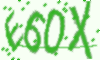

In [59]:
imageList, codeList = getData(1)
imageList[0]

In [60]:
codeList[0]

'E6OX'

In [61]:
x_data = map(imageToVertor, imageList)
y_data = map(codeToVertor, codeList)
p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})

In [62]:
print 'prediction:', map(lambda x: charset[x], p[0])
print 'loss:', l

prediction: ['E']
loss: 0.030009
